# EECE5644 Assignment 1

Going over "solutions" for Assignment 1.

## Imports

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [2]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        # If dealing with a univariate Gaussian, use norm.rvs to sample RVs and not the multivariate version
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['mu'][l-1], pdf_params['Sigma'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['mu'][l-1], pdf_params['Sigma'][l-1], Nl)
    
    return X, labels

## Evaluation Functions

In [3]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    # The epsilon is just to account for the two extremes of the ROC curve (TPR=FPR=0 and TPR=FPR=1)
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]
    
    # Retrieve indices where FPs occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where TPs occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]
    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas

def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['TNR'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['FPR'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['FNR'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['TPR'] = len(ind_11) / N_labels[1]

    return class_metrics

## Classifiers

In [4]:
def perform_lda(X, labels, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance matrix parameters would be estimated from training samples.
    
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """
    
    # First, estimate the class-conditional PDF mean and covariance matrices from samples
    # Note that reshape ensures my return mean vectors are of 2D shape (column vectors nx1)
    mu = np.array([np.mean(X[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(X[labels == i].T) for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z


# ERM classification rule (min prob. of error classifier IF 0-1 loss)
def perform_erm_classification(X, Lambda, gmm_params, C):    
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    # If 0-1 loss, you could instead compute MAP result: np.argmax(class_posteriors, axis=0)
    return np.argmin(risk_mat, axis=0)

## Question 1

The probability density function (PDF) for a 3-dimensional real-valued random vector $\mathbf{X}$ is as follows: $p(\mathbf{x}) = p(\mathbf{x}\,|\,L=0)p(L=0) + p(\mathbf{x}\,|\,L=1)p(L=1)$. Here $L$ is the true class label that indicates which class-label-conditioned PDF generates the data. 

The class priors are $p(L=0)=0.65$ and $p(L=1)=0.35$. 
The class-conditional PDFs are $p(\mathbf{x}\,|\,L=0)=\mathcal{N}(\mathbf{x}\,|\,\boldsymbol{\mu}_0,\boldsymbol{\Sigma}_0)$ and $p(\mathbf{x}\,|\,L=1)=\mathcal{N}(\mathbf{x}\,|\,\boldsymbol{\mu}_1,\boldsymbol{\Sigma}_1)$, where $\mathcal{N}(\mathbf{x}\,|\,\boldsymbol{\mu},\boldsymbol{\Sigma})$ is a multivariate Gaussian probability density function with mean vector $\boldsymbol{\mu}$ and covariance matrix $\boldsymbol{\Sigma}$. The parameters of the class-conditional Gaussian PDFs are:

\begin{equation*}
    \boldsymbol{\mu}_0=\begin{bmatrix} -1/2\\-1/2\\-1/2 \end{bmatrix}, \quad \quad
    \boldsymbol{\Sigma}_0=\begin{bmatrix}1 & -0.5 & 0.3 \\-0.5 & 1 & -0.5 \\ 0.3 & -0.5 & 1\end{bmatrix}, \quad \quad
    \boldsymbol{\mu}_1=\begin{bmatrix}1\\1\\1\end{bmatrix}, \quad \quad
    \boldsymbol{\Sigma}_1=\begin{bmatrix}1 & 0.3 & -0.2 \\0.3 & 1 & 0.3 \\ -0.2 & 0.3 & 1\end{bmatrix}.
\end{equation*}

To produce numerical results as requested below, generate $N=10000$ samples according to this data distribution. Keep track of the true class labels for each sample. Use the same dataset in all the 'Parts' described below.

[6490 3510]


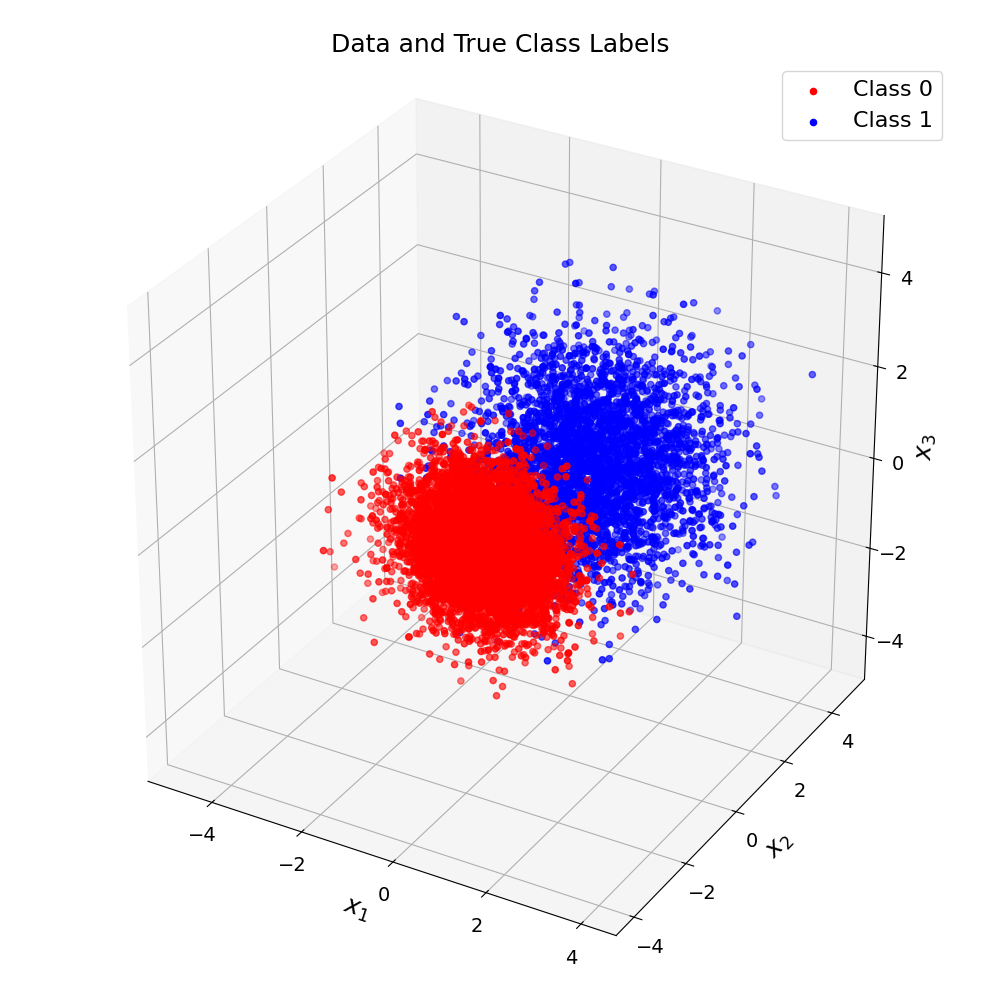

In [5]:
# Generate dataset from two different 3D Gaussian distributions/categories
N = 10000

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.65, 0.35])
num_classes = len(gmm_pdf['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['mu'] = np.array([[-0.5, -0.5, -0.5],
                         [1, 1, 1]])  # Gaussian distributions means
gmm_pdf['Sigma'] = np.array([[[1, -0.5, 0.3],
                          [-0.5, 1, -0.5],
                          [0.3, -0.5, 1]],
                         [[1, 0.3, -0.2],
                          [0.3, 1, 0.3],
                          [-0.2, 0.3, 1]]])  # Gaussian distributions covariance matrices

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))

ax_raw = fig.add_subplot(111, projection='3d')

X, labels = generate_data_from_gmm(N, gmm_pdf)

n = X.shape[1]
L = np.array(range(num_classes))

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)

ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels == 0, 2], c='r', label="Class 0")
ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='b', label="Class 1")
ax_raw.set_xlabel(r"$x_1$")
ax_raw.set_ylabel(r"$x_2$")
ax_raw.set_zlabel(r"$x_3$")
# Set equal axes for 3D plots
ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

### Part A: ERM Classification using Knowledge of True Data PDF

Specify the minimum expected risk classification rule in the form of a likelihood-ratio test: $\frac{p(\mathbf{x}\,|\,L=1)}{p(\mathbf{x}\,|\,L=0)}\stackrel{?}{>}\gamma$, where the threshold $\gamma$ is a function of class priors and fixed (non-negative) loss values. These loss values (denoted as $\lambda_{ij}$) apply to each of the four cases $D=i\,|\,L=j$, where $i, j \in 0, 1$ and $D$ is the decision label.

> We will consider $\lambda_{ij} = \mathrm{Loss}(D=i\,|\,L=j)$, where $\lambda_{ij}$ is the loss associated with classifying an observation as label $i$ given that the true label was $j$. The likelihood ratio test used for classifying an observation $\mathbf{x}$ is given by:

\begin{equation*}
\frac{p(\mathbf{x}\,|\,L=1)}{p(\mathbf{x}\,|\,L=0)} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \gamma \triangleq \frac{(\lambda_{10} - \lambda_{00})}{(\lambda_{01} - \lambda_{11})} \frac{p(L=0)}{p(L=1)}.
\end{equation*}

> Equating the RHS of the equation as $\gamma$ and taking the log of both sides, leads to the following decision rule:

\begin{equation*}
\ln{p(\mathbf{x}\,|\,L=1)} - \ln{p(\mathbf{x}\,|\,L=0)} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \ln{\gamma}.
\end{equation*}

Implement this classifier and apply it to the 10K samples you generated. Vary the threshold $\gamma$ gradually from 0 to $\infty$, and for each threshold value compute the true-positive (detection) probability $p(D=1\,|\,L=1;\gamma)$ and the false-positive (false alarm) probability $p(D=1\,|\,L=0;\gamma)$. Using these paired values, trace/plot an approximation of the ROC curve of the minimum expected risk classifier. Note that at $\gamma \approx 0$ the ROC curve should be at $(\begin{smallmatrix} 1\\1 \end{smallmatrix})$, and as $\gamma$ increases it should traverse towards $(\begin{smallmatrix} 0\\0 \end{smallmatrix})$. Due to the finite number of samples used to estimate probabilities, your ROC curve approximation should reach this destination value for a finite threshold value. Keep track of $p(D=0|L=1;\gamma)$ and $p(D=1|L=0;\gamma)$ values for each $\gamma$, as you will use these values in the following parts.

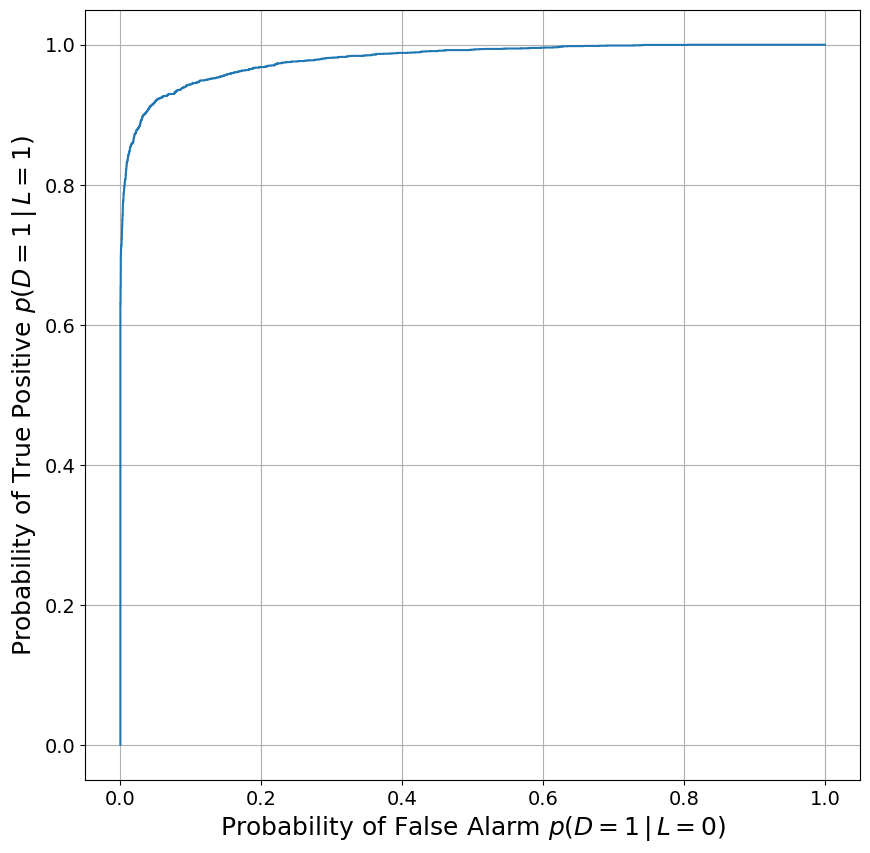

In [6]:
# Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['mu'][l], gmm_pdf['Sigma'][l]) for l in L])
# Class conditional log likelihoods equate to log gamma at the decision boundary
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds
# and 2 rows are the FPR and TPR respectively

plt.ioff() # Interactive plotting off
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion()

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")

plt.grid(True)
display(fig_roc)
fig_roc;

Determine and report the threshold value that achieves minimum probability of error. Superimpose clearly on the ROC curve (using a different color/shape marker) the true-positive and false-positive values attained by this minimum-$\text{Pr}(\text{error})$ classifier. Calculate and report an estimate of the minimum probability of error that is achievable for this data distribution. Note that $\text{Pr}(\text{error};\gamma)=p(D=1\,|\,L=0;\gamma)p(L=0)+p(D=0\,|\,L=1;\gamma)p(L=1)$, where you should use sample estimates of class priors $p(L=j)$, like in the [notebook example](../erm_decision_theory/erm_gmm.ipynb), as you wish to evaluate error rates based on the dataset generated. How does your empirically selected $\gamma$ value that minimizes $\text{Pr}(\text{error})$ compare with the theoretically optimal threshold you compute from the priors and loss values?

> Assume 0-1 loss, as no other loss matrix $\boldsymbol{\Lambda}$ has been specified.

Min Empirical Pr(error) for ERM = 0.056
Min Empirical Gamma = 1.427
Min Theoretical Pr(error) for ERM = 0.059
Min Theoretical Gamma = 1.857


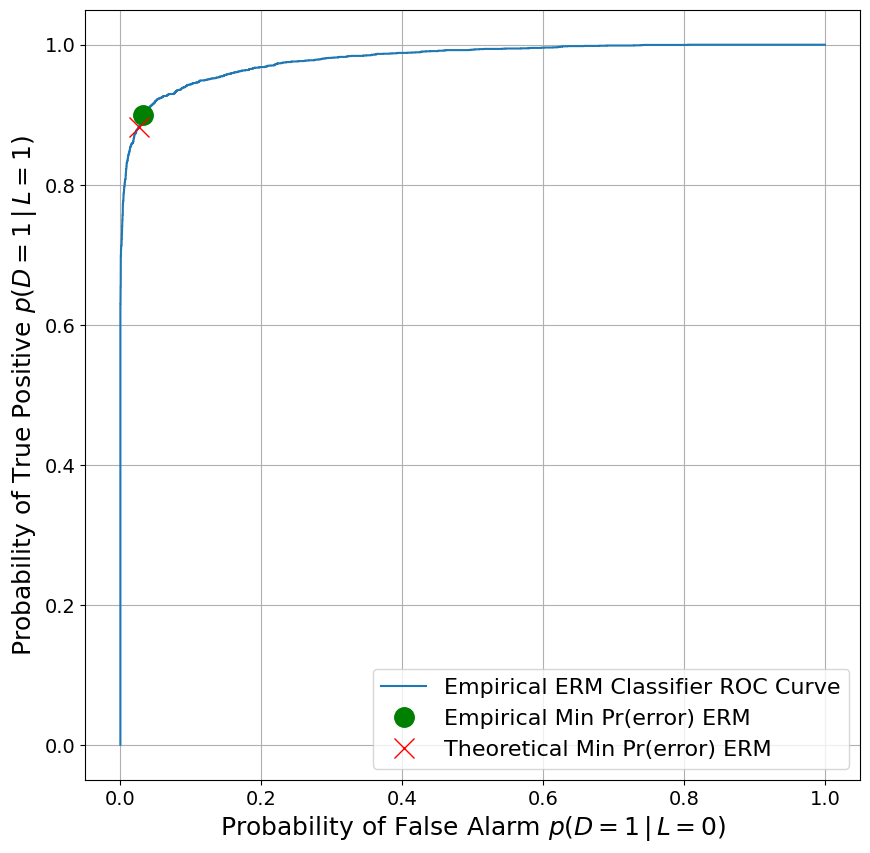

In [7]:
# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / N)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = gmm_pdf['priors'][0] / gmm_pdf['priors'][1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['FPR'] * gmm_pdf['priors'][0] + 
                               class_metrics_map['FNR'] * gmm_pdf['priors'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
plt.legend()

print("Min Empirical Pr(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

display(fig_roc)

### Part B: ERM Classification Attempt using Incorrect Knowledge of Data Distribution

For this part, you will implement a Naive Bayesian Classifier, which assumes features are independent given each class label. Let's assume that you know the true class prior probabilities, but for some reason you think that the class-conditional PDFs are both Gaussian with the (correct) true means described above, but (incorrect) covariance matrices. In particular, you choose for both covariance matrices to be equal to the identity matrix (with diagonal entries equal to true variances, off-diagonal entries equal to zeros, consistent with the independent feature assumption of Naive Bayes). Analyze the impact of this model mismatch using the Naive Bayesian classifier design by repeating the same steps in <b>Part A</b> on the same 10K sample dataset you generated earlier. Report the same results, answer the same questions. Did this model mismatch negatively impact your ROC curve and minimum achievable probability of error?

Min Naive Pr(error) for ERM = 0.068
Min Naive Gamma = 0.939


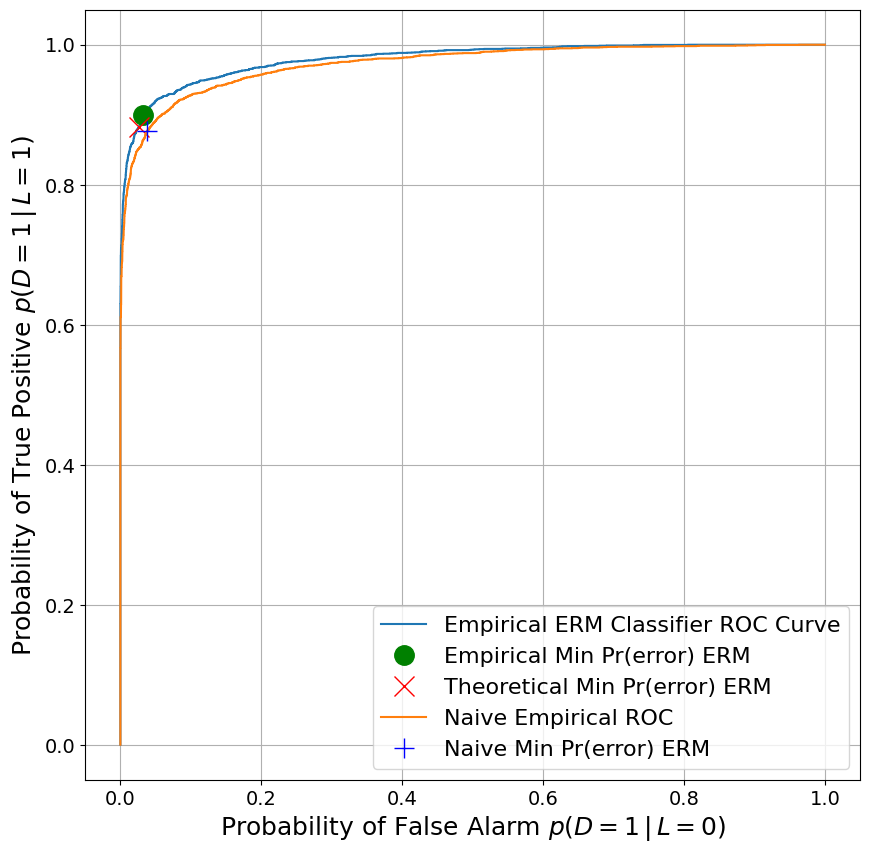

In [8]:
# Naive Bayes case assume conditional independence with features, zero covariance, zero off-diagonals
# Happens to be identity matrix in this question
naive_class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['mu'][l], np.eye(n)) for l in L])
# Class conditional log likelihoods equate to log gamma at the decision boundary
discriminant_score_naive = np.log(naive_class_conditional_likelihoods[1]) - np.log(
    naive_class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_naive, gammas_naive = estimate_roc(discriminant_score_naive, labels)

# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_naive = np.array((roc_naive['p10'], (1 - roc_naive['p11']))).T.dot(N_per_l / N)

# Min prob error for the naive classifier gamma thresholds
min_prob_error_naive = np.min(prob_error_naive)
min_ind_naive = np.argmin(prob_error_naive)

# Plot naive min prob error
ax_roc.plot(roc_naive['p10'], roc_naive['p11'], label="Naive Empirical ROC")
ax_roc.plot(roc_naive['p10'][min_ind_naive], roc_naive['p11'][min_ind_naive], 'b+', label="Naive Min Pr(error) ERM",
            markersize=14)
ax_roc.legend()

print("Min Naive Pr(error) for ERM = {:.3f}".format(min_prob_error_naive))
print("Min Naive Gamma = {:.3f}".format(np.exp(gammas_naive[min_ind_naive])))

display(fig_roc)

### Part C: Fisher's Linear Discriminant Analysis

In the third part of this exercise, repeat the same steps as in the previous two parts, but this time using a Fisher's Linear Discriminant Analysis (LDA) classifier. Given the available 10K samples, estimate the class-conditional PDF mean and covariance matrices using sample average estimators (i.e. the estimated mean vector and covariance matrix from the 10K samples). From these sample-based estimates of mean and covariance, determine the Fisher's LDA projection weight vector (via the generalized eigendecomposition of within- and between-class scatter matrices): $\mathbf{w}_{LDA}$. Trace the ROC curve for the classification rule $\mathbf{w}_{LDA}^\intercal\mathbf{x}$ compared against a threshold $\gamma$ that varies from $-\infty$ to $\infty$. Identify the threshold at which the probability of error (based on sample count estimates) is minimized, and clearly mark that operating point on the ROC curve. Discuss how this LDA classifier performs relative to the previous two classifiers.

<i>Note: When finding the Fisher's LDA projection matrix, do not be concerned about the difference in class priors. When determining the between-class and within-class scatter matrices, use equal weights for the class means and covariances, like in the [Fisher's LDA notebook](../linear_classification/fisher_lda.ipynb).</i>

Min LDA Pr(error) for ERM = 0.351
Min LDA Gamma = 3.629


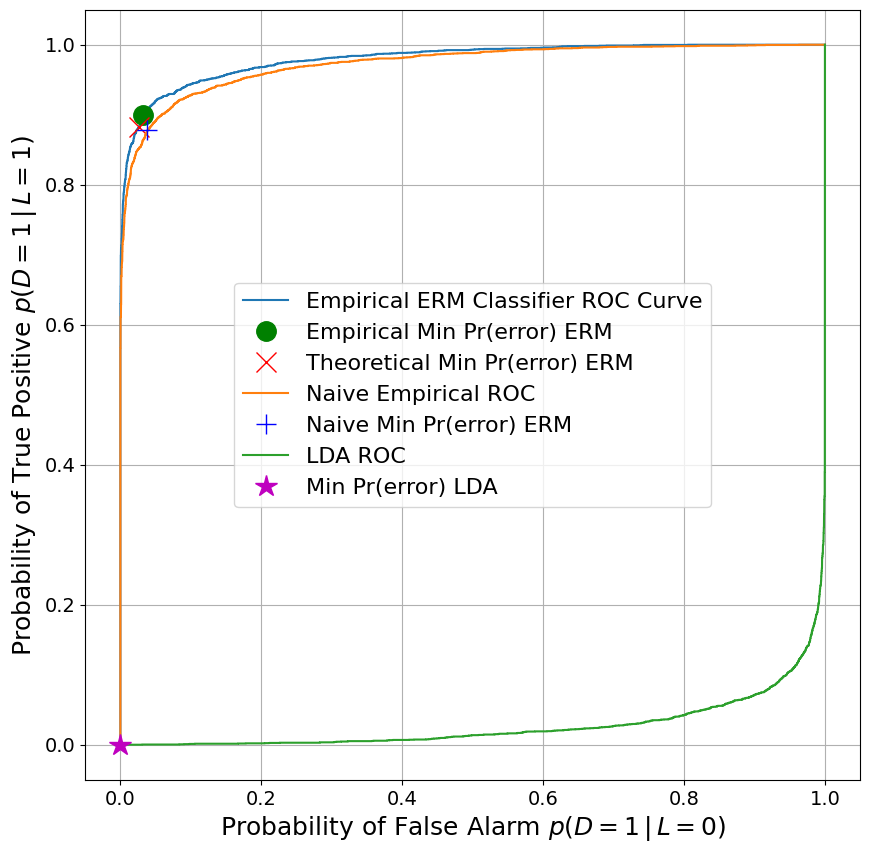

In [9]:
# Fisher LDA Classifer (using sample average estimates for model parameters)
_, discriminant_score_lda = perform_lda(X, labels)

# Estimate the ROC curve for this LDA classifier
roc_lda, gamma_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda['p10'], (1 - roc_lda['p11']))).T.dot(N_per_l / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind_lda = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda['p10'], roc_lda['p11'], label="LDA ROC")
ax_roc.plot(roc_lda['p10'][min_ind_lda], roc_lda['p11'][min_ind_lda], 'm*', label="Min Pr(error) LDA",  markersize=16)
ax_roc.legend()


print("Min LDA Pr(error) for ERM = {:.3f}".format(min_prob_error_lda))
print("Min LDA Gamma = {:.3f}".format(np.real(gamma_lda[min_ind_lda])))

display(fig_roc)

> Since the MAP classifier is designed to minimize probability error (when implemented with true class conditional likelihoods and class priors, as in <b>Part A</b>), we would expect its error probability to be lower than that of all other classifiers, including the Naive Bayes classifier and Fisher's LDA from <b>Parts B \& C</b>, respectively. The numerical experiment is consistent with this theoretical result.

> In both cases, model mismatch causes a reduction in classification accuracy, however not to any significant effect. For Naive Bayes, this is likely because the <i>Naive assumption</i> of conditional independence does not affect the data distributions greatly. More specifically, the covariance values associated with the class-conditional PDFs are not a source of major overlap in the data-generating distributions. Similarly, the class-conditional PDFs are clearly separable enough to be considered "linearly separable", which in turn means Fisher's LDA can also perform effectively on this dataset. Therefore, most of the error in this problem using the classifiers of <b>Parts B \& C</b> continues to originate from its <b>Bayes error</b> (irreducible error) rather than model error.

## Question 2

A 2-dimensional random vector $\mathbf{X}$ takes values from a mixture of four Gaussians. Each Gaussian PDF is the class-conditional PDF for one of four class labels $L\in \{1,2,3,4\}$. For this problem, pick your own four distinct Gaussian class-conditional PDFs $p(\mathbf{x}\,|\,L=j),~j\in\{1,2,3,4\}$. Set class priors to $0.2,0.25,0.25,0.3$. Select your Gaussian class-conditional PDFs to have mean vectors approximately equally spaced out along a line, and the covariance matrices to be scaled versions of the identity matrix (with scale factors leading to a significant amount of overlap between the data from these Gaussians). Label these classes according to the ordering of mean vectors along the line, so that classes have consecutive integer labels.

In [10]:
n = 2 # dimensionality of input random vectors
C = 4 # number of classes

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.2, 0.25, 0.25, 0.3])

# Set mean vectors to be equally spaced out along a line in order
gmm_pdf['mu'] = np.array([1*np.ones(n), 2*np.ones(n), 3*np.ones(n), 4*np.ones(n)])

# Set covariance matrices so that there is significant overlap between these
# distributions with means given above
gmm_pdf['Sigma'] = np.array([3*np.eye(n), 3*np.eye(n), 3*np.eye(n), 3*np.eye(n)])

### Part A: Minimum Probability of Error Classification (0-1 Loss, a.k.a. Bayes Decision Rule or MAP Classifier)

Generate $N=10000$ samples from this data distribution and keep track of the true labels for each sample.

[2009 2506 2456 3029]


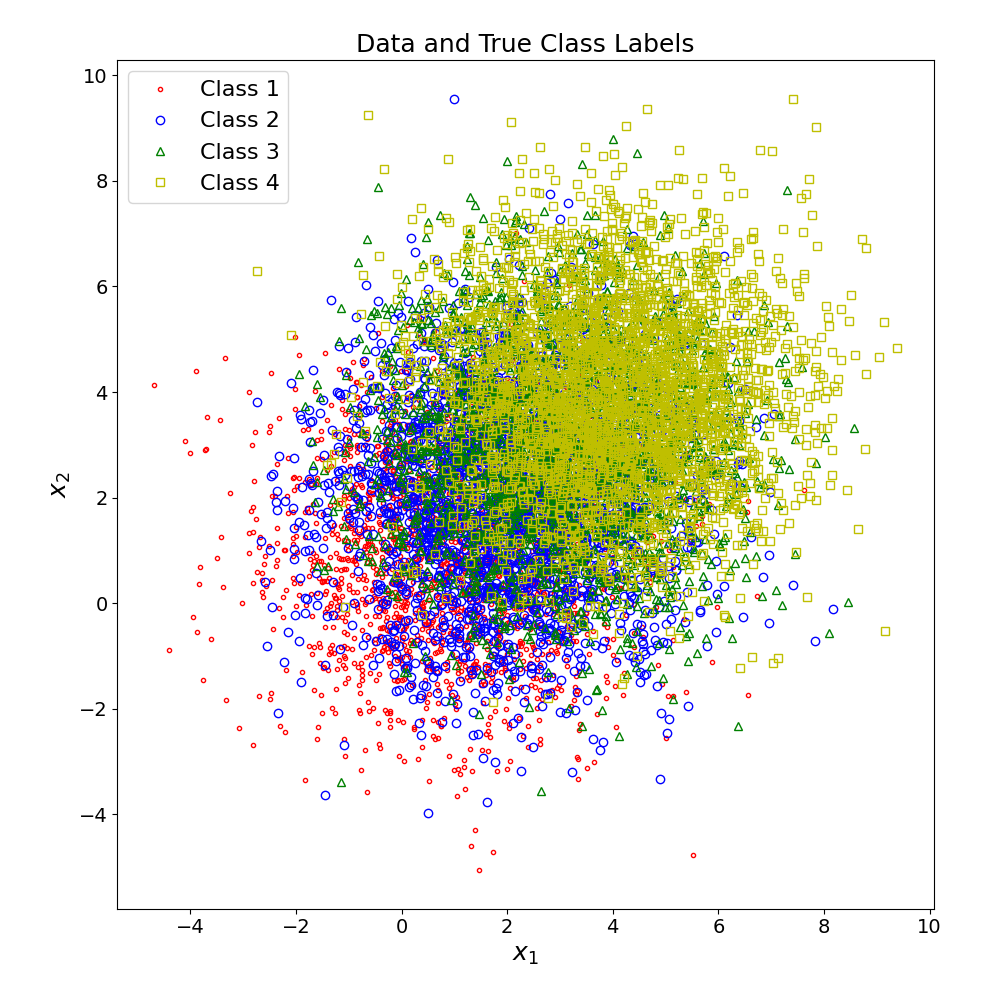

In [11]:
X, labels = generate_data_from_gmm(N, gmm_pdf)

L = np.array(range(C)) # Assuming 0-3 instead of 1-4 to make my life easier in Python

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)

# Plot the original data and their true labels
fig, ax_gmm = plt.subplots(figsize=(10, 10))

ax_gmm.plot(X[labels == 0, 0], X[labels == 0, 1], 'r.', label="Class 1", markerfacecolor='none')
ax_gmm.plot(X[labels == 1, 0], X[labels == 1, 1], 'bo', label="Class 2", markerfacecolor='none')
ax_gmm.plot(X[labels == 2, 0], X[labels == 2, 1], 'g^', label="Class 3", markerfacecolor='none')
ax_gmm.plot(X[labels == 3, 0], X[labels == 3, 1], 'ys', label="Class 4", markerfacecolor='none')
ax_gmm.set_xlabel(r"$x_1$")
ax_gmm.set_ylabel(r"$x_2$")
ax_gmm.set_aspect('equal')

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

Specify the decision rule that achieves minimum probability of error (i.e. use 0-1 loss). Implement this classifier with true data distribution knowledge. Then classify the 10K samples and count the samples corresponding to each decision-label pair so as to empirically estimate the confusion matrix whose entries are $p(D=i\,|\,L=j)$ for $i,j\in\{1,2,3,4\}$. Present results of the confusion matrix and minimum probability of error estimate.

>For a given $\mathbf{x}$, we want to choose a class label $i$ which minimizes risk (or loss) associated with choosing this class label. We know that the <b>ERM decision rule</b> for this problem is based on conditional risk:

\begin{equation*}
D(\mathbf{x}) = \mathop{\rm argmin}_{i\in \{1,2,3,4\}} R(D = i \, | \, \mathbf{x}) = \mathop{\rm argmin}_{i \in \{1,2,3,4\}} \sum_{j=1}^4 \lambda_{ij} p(\mathbf{x}\, | \,L=j)p(L=j),
\end{equation*}

>where the expression expands the class posteriors $p(L=j \, | \, \mathbf{x})$ for $j \in \{1,2,3,4\}$  using Bayes rule.

>[Recall](../erm_decision_theory/erm_gmm.ipynb#ERM-Classification-using-True-Knowledge-of-PDF) that the matrix form is expressed as:

\begin{equation*}
\begin{bmatrix} R(D=1\, | \,\mathbf{x}) \\  R(D=2\, | \,\mathbf{x}) \\ R(D=3\, | \,\mathbf{x}) \\ R(D=4\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \begin{bmatrix} p(L=1\, | \,\mathbf{x}) \\ p(L=2\, | \,\mathbf{x}) \\ p(L=3\, | \,\mathbf{x}) \\ p(L=4\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \, \text{diag}\big(p(L=1), p(L=2), p(L=3), p(L=4)  \big) \begin{bmatrix} p(\mathbf{x}\, | \,L=1) \\ p(\mathbf{x}\, | \,L=2) \\ p(\mathbf{x}\, | \,L=3) \\ p(\mathbf{x}\, | \,L=4) \end{bmatrix}.
\end{equation*}

>The decision $D(\mathbf{x})$ resulting in <b>minimum conditional risk</b> (minimum entry in the vector on the LHS of this equation) will be elected.

Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 5017
Empirically Estimated Probability of Error: 0.5017


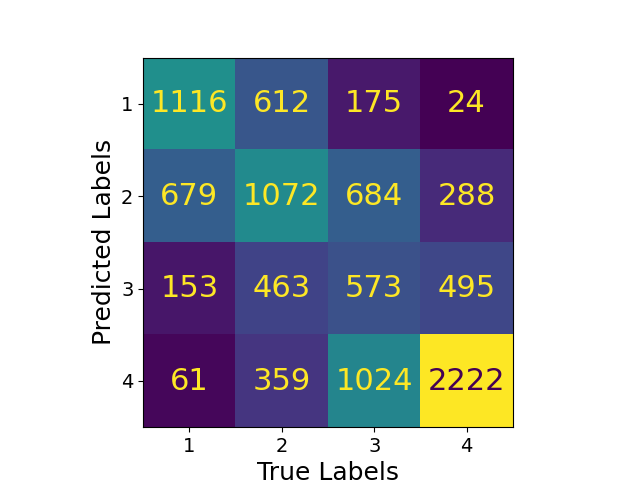

In [12]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((C, C)) - np.eye(C)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, display_labels=['1', '2', '3', '4'], colorbar=False)
plt.ylabel("Predicted Labels")
plt.xlabel("True Labels")

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Provide a visualization of the data (scatter-plot in 2-dimensional space). For each sample indicate the true class label with a different marker shape (dot, circle, triangle, square) and whether it was correctly (green) or incorrectly (red) classified using the marker colors indicated in parentheses.

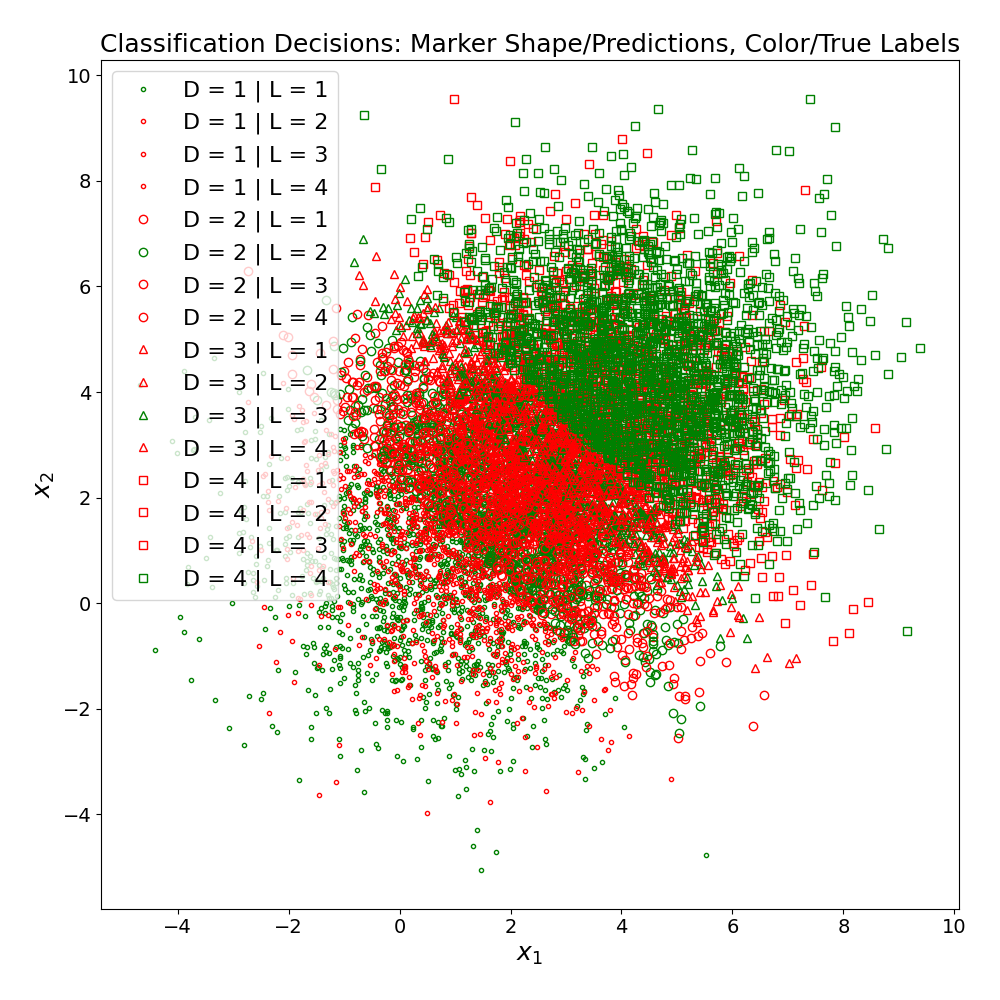

In [13]:
# Plot for decisions vs true labels
fig_map = plt.figure(figsize=(10, 10))

marker_shapes = '.o^s'
for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c))

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c:
            marker = marker_shapes[r] + 'g'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')
        else:
            marker = marker_shapes[r] + 'r'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

### Part B: ERM Classification (Loss Matrix Values that do NOT Correspond to 0-1 Loss)

Repeat the exercise for an ERM classification rule with the following loss values:

\begin{equation*}
    \boldsymbol{\Lambda} =
    \begin{bmatrix}
        0 & 1 & 2 & 3\\
        1 & 0 & 1 & 2\\
        2 & 1 & 0 & 1\\
        3 & 2 & 1 & 0\\
    \end{bmatrix}.
\end{equation*}
    
Given this loss matrix, errors between Gaussian pairs that have higher separation in their means will be penalized more.

Note that, the $(i,j)^{th}$ entry of the loss matrix indicates the loss incurred by deciding on class $i$ when the true label is $j$. For this part, using the 10K samples, estimate the minimum expected risk that this optimal ERM classification rule will achieve. Again present your results with visual and numerical representations. Briefly discuss interesting insights, if any.

<i>Hint: For each sample, determine the loss matrix entry corresponding to the decision-label pair that this sample falls into, and add this loss to an estimate of cumulative loss. Divide cumulative loss by the total number of samples to get average loss as an estimate for expected risk/loss.</i>

Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 5236
Empirically Estimated Probability of Error: 0.5236


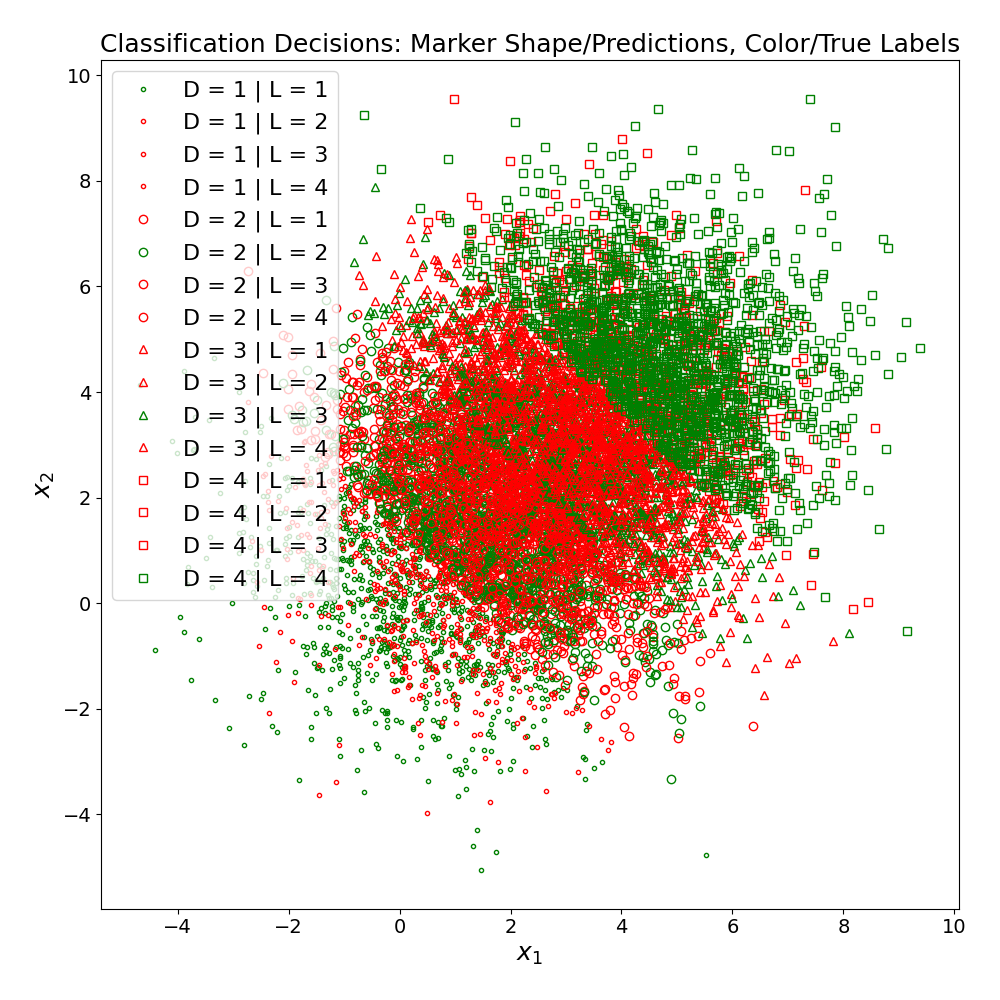

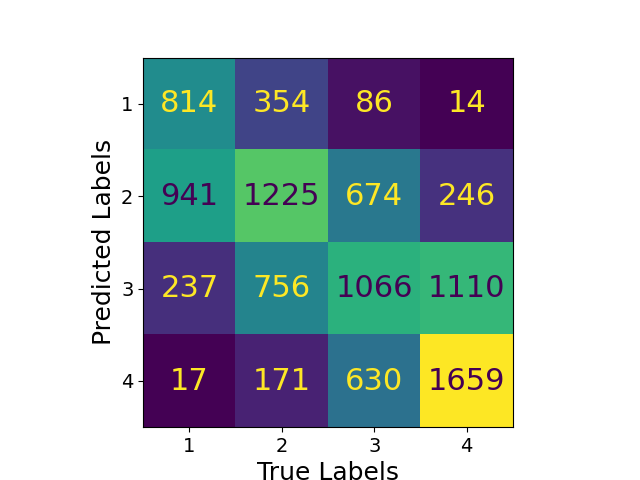

In [14]:
# Create the new loss matrix
Lambda = np.array([[0, 1, 2, 3], 
                   [1, 0, 1, 2], 
                   [2, 1, 0, 1], 
                   [3, 2, 1, 0]])

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, display_labels=['1', '2', '3', '4'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

# Plot for decisions vs true labels
fig_erm = plt.figure(figsize=(10, 10))

marker_shapes = '.o^s'
for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c))

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c:
            marker = marker_shapes[r] + 'g'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')
        else:
            marker = marker_shapes[r] + 'r'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

>The ERM classifier using the loss matrix from <b>Part B</b> differs from <b>Part A</b> in how it penalizes misclassifications made for classes farther away more than those made for adjacent classes. One might expect higher error for <b>Part B's</b> ERM classifier, as a result of using a loss matrix $\boldsymbol{\Lambda}$ that places higher risk than a 0-1 loss function on classifying samples from non-adjacent distributions. Therefore, the priority of the <b>Part B</b> classifer is to correctly classify those few outlier class samples that could be misconstrued for a distant, incorrect class. However, this effect may come at the expense of penalizing errors on the more frequently occurring adjacent class samples less than <b>Part A's</b> classifier.

>Specifically, we would anticipate that <b>Part B's</b> classifier decreases false probability scores over <b>Part A's</b> classifier in the following scenarios $D = 4 \,|\, L = 1$, $D = 1 \,|\, L = 4$ (higher risk associated with deciding class 4 given the class was actually 1, and vice versa), as is demonstrated in the above confusion matrices. This behaviour becomes more pronounced in the presence of class-conditional PDFs with significant overlap.

## Question 3

Implement minimum-probability-of-error classifiers for the following problems, assuming that the class-conditional PDF of features for each class you encounter is Gaussian.

>I used [pandas](https://pandas.pydata.org/) for the dataset parsing aspect of this question. It's an extremely useful and flexible tool when it comes to data manipulation/analysis, so I highly encouraging investigating its features for future use.


### Wine Quality Dataset

Wine Quality dataset located [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality), specifically the <b>white</b> wine dataset. This dataset consists of 11 features and class labels from 0 to 10 indicating wine quality scores. There are 4898 samples.

In [15]:
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                       delimiter=';')

# Sanity check
wine_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  
0         8.8        6  
1         9.5        6  
2        10.1        6  
3         9.9        6  
4         9.9        6  
...       ...      ...  
4893     11.2        6  
4894      9.6        5  
4895      9.4        6  
4896     12.8        7  
4897     11.8        6  

[4898 rows x 12 columns]

Using all available samples from a class, compute sample average estimates for the mean vectors and covariance matrices that parameterize the class-conditional Gaussians. Use sample counts to also estimate the class priors. In case your sample estimates of covariance matrices are ill-conditioned, consider adding a regularization term to your covariance estimate,e.g. $\boldsymbol{\Sigma}_{Regularized} = \boldsymbol{\Sigma}_{SampleAverage} + \lambda\,\mathbf{I}$, where $\lambda>0$ is a small regularization parameter that ensures the regularized covariance matrix $\boldsymbol{\Sigma}_{Regularized}$ has all eigenvalues larger than this parameter. Using regularization in this context will allow you to solve an otherwise ill-posed problem.

In [16]:
def regularized_cov(X, lambda_reg):
    n = X.shape[0]
    sigma = np.cov(X)
    # Selecting the regularization parameter should be performed using cross-validation and a separate data subset
    # As I only went by training set performance (overfitting) in this problem, I settled on lambda=1/n
    sigma += lambda_reg * np.eye(n)
    return sigma

# Total number of rows/samples
N = len(wine_df.index)

# iloc accesses rows/columns by indexing 
# Extracting data matrix X and target labels vector
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Define a label encoder to make indexing easy and encode labels as 0, 1, ..., C, rather than 4, 5, ... etc
le = preprocessing.LabelEncoder()
le.fit(qualities)
labels = le.transform(qualities)

# Estimate class priors
gmm = {}
gmm['priors'] = (wine_df.groupby(['quality']).size() / N).to_numpy() 
# Infer number of classes from priors
num_classes = len(gmm['priors'])

gmm['mu'] = wine_df.groupby(['quality']).mean().to_numpy() 
# Infer number of features from priors
n = gmm['mu'].shape[1]

gmm['Sigma'] = np.array([regularized_cov(X[labels == l].T, (1/n)) for l in range(num_classes)])

N_per_l = np.array([sum(labels == l) for l in range(num_classes)])
print(N_per_l)

[  20  163 1457 2198  880  175    5]


With these estimated ("trained") Gaussian class-conditional PDFs and class priors, apply the minimum-$\text{Pr}(\text{error})$ classification rule on all ("training") samples. Then count the errors and report the error probability estimate you obtain for each problem, as well as the confusion matrices for this classification rule. 

Confusion Matrix (rows: Predicted class, columns: True class):
Total Mumber of Misclassified Samples: 2309
Empirically Estimated Probability of Error: 0.4714


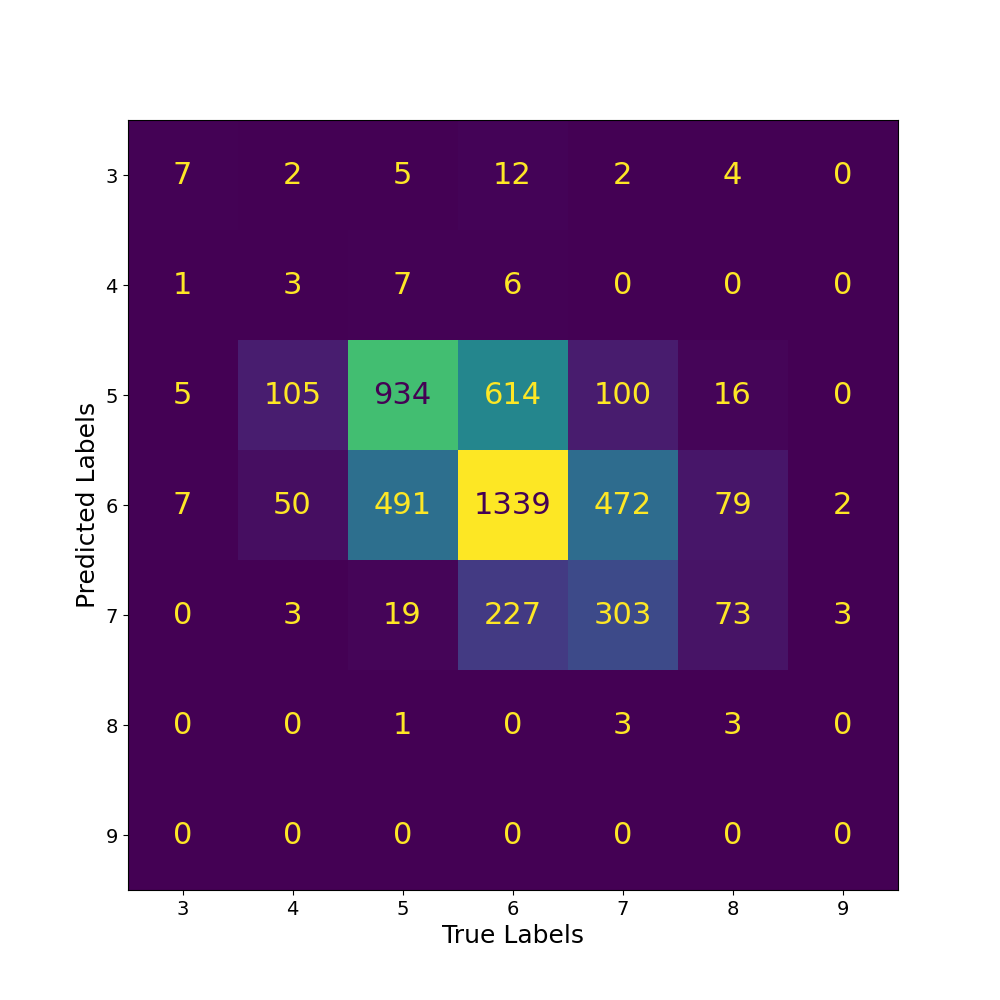

In [17]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
fig, ax = plt.subplots(figsize=(10, 10))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax,
                                                       display_labels=['3', '4', '5', '6', '7', '8', '9'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Visualize the datasets in 2- or 3-dimensional projections of subsets of features and then do the same 2- or 3-dimensional plots using principal component analysis (PCA). Discuss the following:

- If Gaussian class-conditional models are appropriate for these datasets, commenting on the differences in how feature-subsets or PCA helped you draw your conclusions
- How your model choice of a Gaussian might have influenced the confusion matrix and probability of error values you obtained
- Any modeling assumptions, e.g. how you estimated/selected necessary parameters for your model and classification rule

Describe your analyses in mathematical terms supplemented by numerical and visual results, conveying your understanding of what you have accomplished and demonstrated.

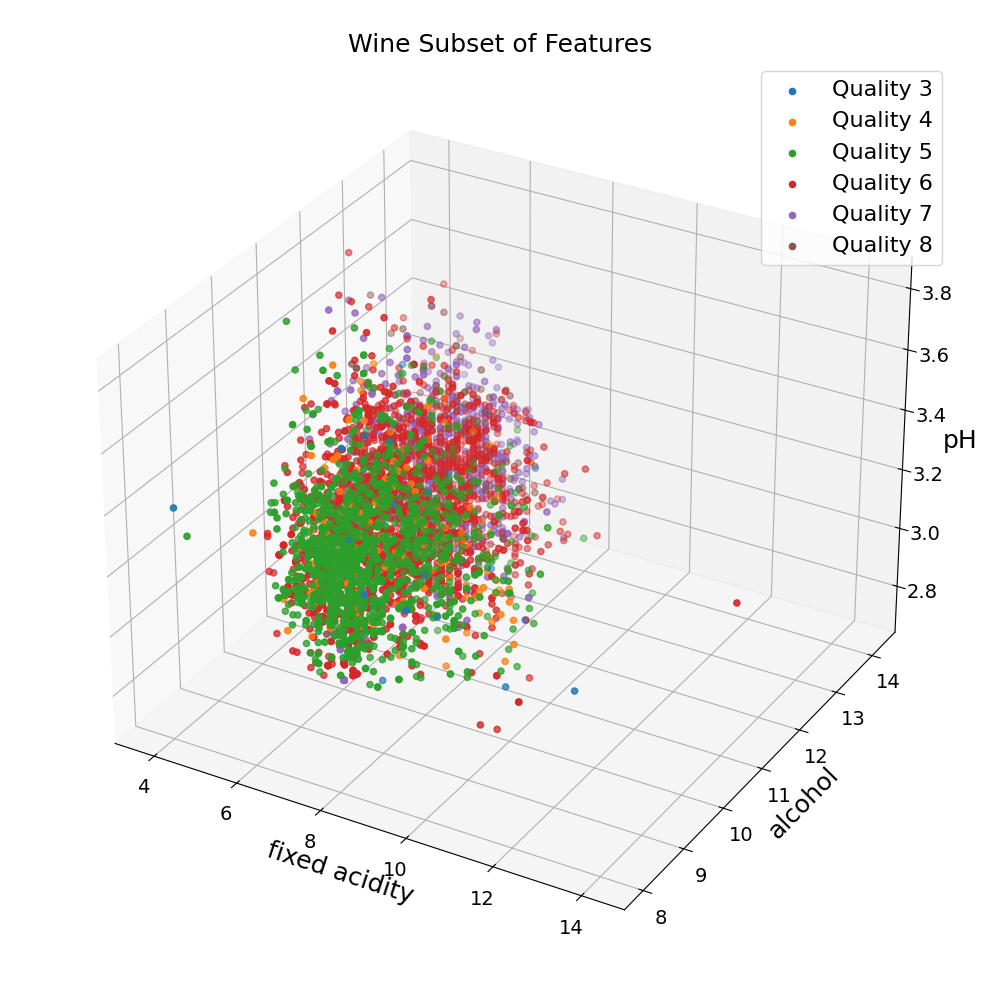

In [18]:
fig = plt.figure(figsize=(10, 10))

ax_subset = fig.add_subplot(111, projection='3d')

unique_qualities = np.sort(wine_df['quality'].unique())
for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_subset.scatter(wine_df[wine_df['quality']==q]['fixed acidity'], 
                      wine_df[wine_df['quality']==q]['alcohol'], 
                      wine_df[wine_df['quality']==q]['pH'], label="Quality {}".format(q))
    
ax_subset.set_xlabel("fixed acidity")
ax_subset.set_ylabel("alcohol")
ax_subset.set_zlabel("pH")

# Set equal axes for 3D plots to realize the additional challenges in visualization
# ax_subset.set_box_aspect((np.ptp(wine_df['fixed acidity']), np.ptp(wine_df['alcohol']), np.ptp(wine_df['pH'])))

plt.title("Wine Subset of Features")
plt.legend()
plt.tight_layout()
plt.show()

>The purpose of asking you to plot feature subsets or perform PCA over the data was to visualize the "Gaussian-like" resemblance of the data. As a key assumption in your model that the class-conditional PDFs are Gaussian, it is a sensible idea to validate this assumption by inspecting the data. Normally this step should take place prior to any classification, or deriving of probability of error estimates.

>The subset of features part of the task was to illustrate that it's challenging to select appropriate feature subsets of 2/3-dimensions to plot... Even though $n=11$ is still fairly manageable, what about the HAR dataset with $n=561$ in [the following question](#Human-Activity-Recognition)? Domain knowledge would be immensely helpful in selecting these subsets, but we often lack such information. <i>I personally chose arbitrary features over a similar range of values, as I'm no wine expert</i>.

>A better approach here would be to employ a dimensionality reduction technique, such as PCA, which will help us build better intuition of whether we have selected an appropriate model (determined by our Gaussian class-conditional distributions) for the wine-quality classification task:

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


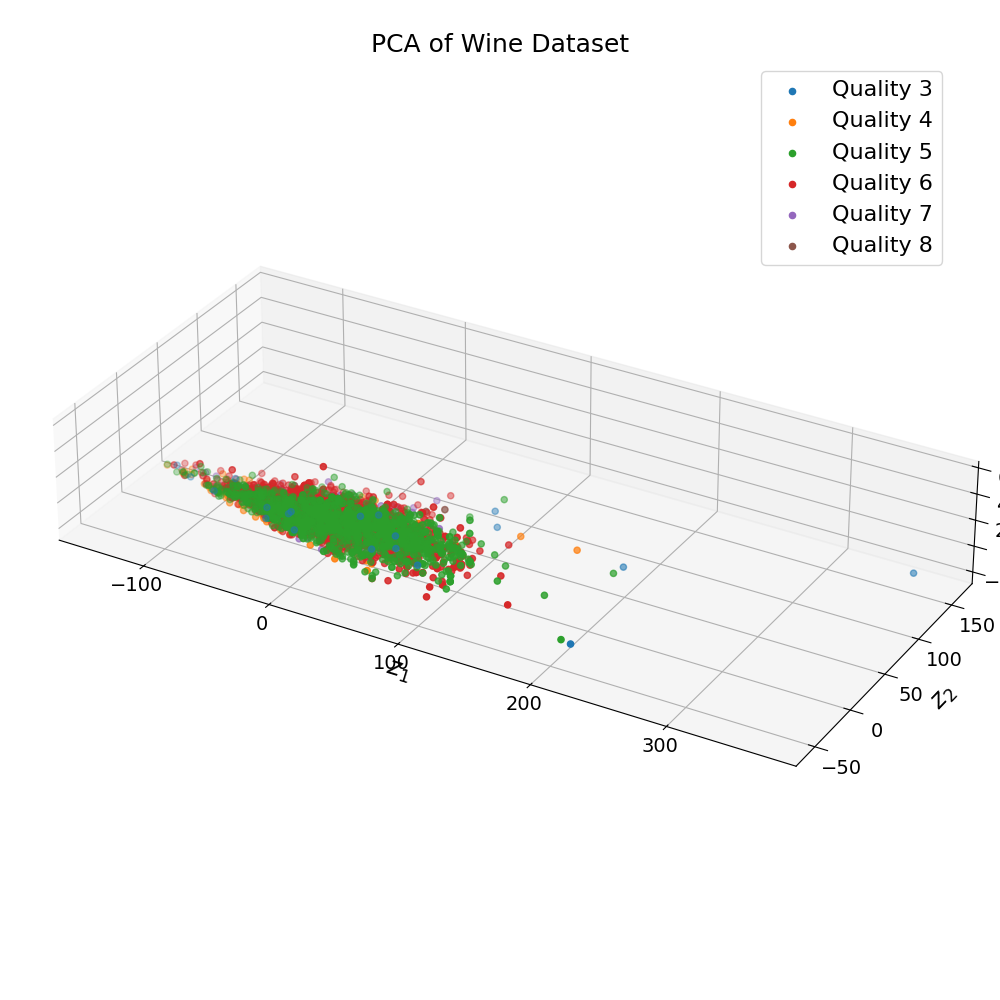

In [19]:
fig = plt.figure(figsize=(10, 10))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_pca.scatter(Z[wine_df['quality']==q, 0], 
                      Z[wine_df['quality']==q, 1], 
                      Z[wine_df['quality']==q, 2], label="Quality {}".format(q))
    
ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Wine Dataset")
plt.legend()
plt.tight_layout()
plt.show()

>The PCA procedure was effective at reducing the dimensionality of the data (fraction of variance explained primarily captured in the first three PCs), with a general Gaussian-like shape emerging (elliptical patterns). However, for this small $N$ case ([Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)), the data is unlikely to follow a typical Gaussian distribution and our Gaussian assumption will introduce <b>model error</b>.

>The most likely source for high probability of error estimates in this problem is due to <b>irreducible error</b>. The labeled projection plots illustrate significant amounts of overlap between the class-specific Gaussian PDFs, suggesting our model will struggle to correctly discriminate between classes based on conditional likelhood. The confusion matrix further highlights the effect of this overlap, demonstrating that classes are often mislabeled as middle wine quality scores (e.g., 5, 6 or 7), which are the most frequently occurring qualities with class-conditional PDFs responsible for the majority of spread in the data.

>Overall, another model should be chosen for this task in order to clearly distinguish between the classes, as our Gaussian assumption is not entirely appropriate.


### Human Activity Recognition

Human Activity Recognition dataset located [here](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones), which consists of 561 features and 6 activity labels. There are 10299 samples.

> Not a complete answer to this question but some quick code has been put together for reference.

In [20]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

# Reads zip file without writing to disk by emulating the file using a BytesIO buffer class 
resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip')
har_zip = ZipFile(BytesIO(resp.read()))
har_train_df = pd.read_csv(har_zip.open('UCI HAR Dataset/train/X_train.txt'), delim_whitespace=True, header=None)
har_test_df = pd.read_csv(har_zip.open('UCI HAR Dataset/test/X_test.txt'), delim_whitespace=True, header=None)
har_df = pd.concat([har_train_df, har_test_df])

# Sanity check
har_df

# You can obtain the labels in a similar way^

0         1         2         3         4         5         6    \
0     0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1     0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2     0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3     0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4     0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
...        ...       ...       ...       ...       ...       ...       ...   
2942  0.310155 -0.053391 -0.099109 -0.287866 -0.140589 -0.215088 -0.356083   
2943  0.363385 -0.039214 -0.105915 -0.305388  0.028148 -0.196373 -0.373540   
2944  0.349966  0.030077 -0.115788 -0.329638 -0.042143 -0.250181 -0.388017   
2945  0.237594  0.018467 -0.096499 -0.323114 -0.229775 -0.207574 -0.392380   
2946  0.153627 -0.018437 -0.137018 -0.330046 -0.195253 -0.164339 -0.430974   

           7         8         9    ...       551       552       553  \
0    -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304   
1    -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499   
2    -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104   
3    -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845   
4    -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205   
...        ...       ...       ...  ...       ...       ...       ...   
2942 -0.148775 -0.232057  0.185361  ...  0.074472 -0.376278 -0.750809   
2943 -0.030036 -0.270237  0.185361  ...  0.101859 -0.320418 -0.700274   
2944 -0.133257 -0.347029  0.007471  ... -0.066249 -0.118854 -0.467179   
2945 -0.279610 -0.289477  0.007471  ... -0.046467 -0.205445 -0.617737   
2946 -0.218295 -0.229933 -0.111527  ... -0.010386 -0.072237 -0.436940   

           554       555       556       557       558       559       560  
0    -0.112754  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1     0.053477 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2    -0.118559  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3    -0.036788 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4     0.123320  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  
...        ...       ...       ...       ...       ...       ...       ...  
2942 -0.337422  0.346295  0.884904 -0.698885 -0.651732  0.274627  0.184784  
2943 -0.736701 -0.372889 -0.657421  0.322549 -0.655181  0.273578  0.182412  
2944 -0.181560  0.088574  0.696663  0.363139 -0.655357  0.274479  0.181184  
2945  0.444558 -0.819188  0.929294 -0.008398 -0.659719  0.264782  0.187563  
2946  0.598808 -0.287951  0.876030 -0.024965 -0.660080  0.263936  0.188103  

[10299 rows x 561 columns]

Explained variance ratio:  [0.62227069 0.04772595 0.04018191]


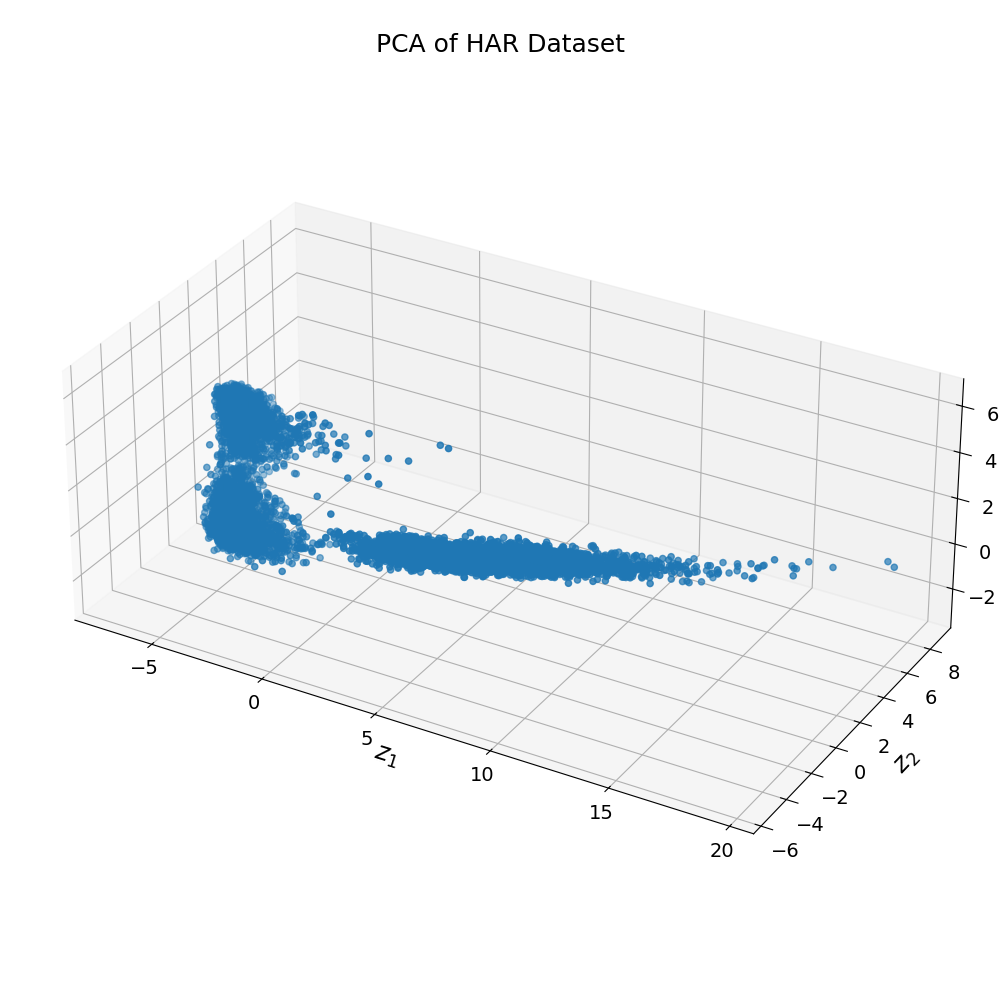

In [21]:
# Extracting data matrix X
X = har_df.to_numpy()

fig = plt.figure(figsize=(10, 10))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

ax_pca.scatter(Z[:, 0], Z[:, 1], Z[:, 2])
    
ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of HAR Dataset")
plt.tight_layout()
plt.show()

>Still doesn't appear Gaussian-like (even when viewing each blob as a separate component distribution). Nevertheless, we have higher $N$ here (Central Limit Theorem assumption of tending towards Gaussian), so we might anticipate that a Gaussian model will perform well, or at least better than in the Wine Quality dataset case. Moreover, even without labeled scatter points, the separation between "blobs" ([why blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)) will also hopefully improve our odds of classifying the activity labels from this dataset using a Gaussian-based model.